I want to see if there are specific changes in patches that affect the price of items. My hypothesis is when guns are improved or weakened, they will increase or decrease in popularity, and their skin prices will change.
To do this I want to find words or phrases that appear more frequently in patches near the times when price anomalies occur.

Attempt 1:
Perform clustering on all of the patches, then find a cluster with only anomaly patches. With the patches in that cluster, run NLP to find the most important words or phrases.

<br><br>
First things first, let's graph the dates of all of the patches on top of the dates of the top anomalies to make sure there is some overlap.

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
%matplotlib inline
with open('archive/gun_anomalies.pkl', 'rb') as f:
    anoms = pickle.load(f)
client = MongoClient()
db = client['steam_capstone']
collection = db['patches']
cur = collection.find({'date':{'$exists':True}})
patch_dates = [x['date'] for x in cur]

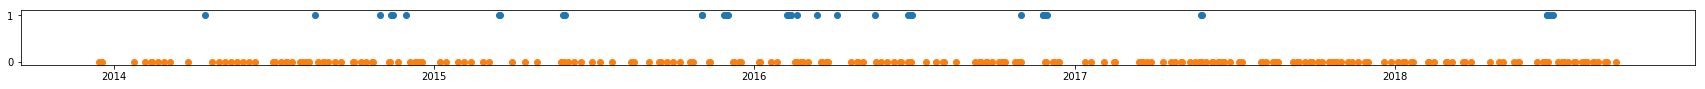

In [17]:
top_anoms = sorted([(y, x) for x, y in anoms], reverse=True)[:50]
fig, ax = plt.subplots(figsize=(30, 1))
_=ax.scatter([d[1] for d in top_anoms], [1]*len(top_anoms))
_=ax.scatter(patch_dates, [0]*len(patch_dates))

To the naked eye it seems that some actually fall between patches

In [38]:
# anom dates farthest from patches
from itertools import compress
top_anoms_no_june = compress(top_anoms, [x < pd.Timestamp('2018-06-01 00:00:00') for _,x in top_anoms])
sorted([(y, x)for x, y in [(anom_date, anom_date - max(compress(patch_dates, [p < anom_date for p in patch_dates]))) for _,anom_date in top_anoms_no_june]], reverse=False)

[(Timedelta('1 days 00:00:00'), Timestamp('2014-11-13 00:00:00')),
 (Timedelta('1 days 00:00:00'), Timestamp('2015-05-30 00:00:00')),
 (Timedelta('1 days 00:00:00'), Timestamp('2016-06-25 00:00:00')),
 (Timedelta('1 days 00:00:00'), Timestamp('2016-06-29 00:00:00')),
 (Timedelta('1 days 00:00:00'), Timestamp('2016-11-29 00:00:00')),
 (Timedelta('1 days 00:00:00'), Timestamp('2016-11-30 00:00:00')),
 (Timedelta('1 days 00:00:00'), Timestamp('2017-05-25 00:00:00')),
 (Timedelta('2 days 00:00:00'), Timestamp('2014-11-14 00:00:00')),
 (Timedelta('2 days 00:00:00'), Timestamp('2015-05-28 00:00:00')),
 (Timedelta('2 days 00:00:00'), Timestamp('2016-02-19 00:00:00')),
 (Timedelta('2 days 00:00:00'), Timestamp('2016-06-26 00:00:00')),
 (Timedelta('2 days 00:00:00'), Timestamp('2017-05-26 00:00:00')),
 (Timedelta('3 days 00:00:00'), Timestamp('2014-11-15 00:00:00')),
 (Timedelta('3 days 00:00:00'), Timestamp('2015-05-29 00:00:00')),
 (Timedelta('3 days 00:00:00'), Timestamp('2016-06-27 00:00:00

### NLP:
  * Lower
  * Tokenize (split)
  * Remove punctuation
  * Remove stop words
  * Stem
  * Vectorize

In [184]:
import re
import numpy as np
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [92]:
test_patch = collection.find_one()['patch_notes']

In [93]:
test_lower = test_patch.lower()

In [169]:
test_punc_free = [x for x in re.findall(r'(?!\d)[\w]+', test_lower)]

In [171]:
test_stop_free = [x for x in test_punc_free if x not in stopwords.words()]

In [173]:
stemmer = PorterStemmer()
test_tokens = [stemmer.stem(words) for words in test_stop_free]

test_tokens is cleaned, tokenized and stemmed

In [175]:
tf_vec = CountVectorizer()
test_vec = tf_vec.fit_transform(test_tokens)

In [214]:
def stem_patch(patch):
    """
    Given the string of a patch update, tokenize and stem the patch notes
    """
    patch = patch.lower()
    patch = [x for x in re.findall(r'(?!\d)[\w]+', patch)]
    patch = [x for x in patch if x not in stopwords.words()]
    stemmer = PorterStemmer()
    return [stemmer.stem(words) for words in patch]

def flatten(nested_list):
    '''Break down list of lists into list of items'''
    return [item for sublist in nested_list for item in sublist]

def label_anom_patches(patch_dict, anom_dates):
    """
    Given a dict of {date:patch}, return [(notes, 0), (notes, 1)...] 
    where index 1 labels anomalous or not.
    """
    anom_date_range = set(flatten([pd.date_range(date-pd.Timedelta(3, unit='D'), date+pd.Timedelta(3, unit='D')) for date in anom_dates]))
    return [(text, 1) if date in anom_date_range else (text, 0) for date, text in patch_dict.items()]

In [220]:
patch_dict = dict([(x['date'], x['patch_notes']) for x in collection.find()])

In [223]:
labeled_patches = label_anom_patches(patch_dict, [date for _,date in top_anoms])

In [224]:
labeled_tokens = [(stem_patch(patch_notes), label) for patch_notes,label in labeled_patches]

labeled_patches is now a list of `(raw_string, label)` where the `raw_string` is each patch notes, and `label` is whether it's close to an anomalous date or not

In [227]:
data = [x for x, y in labeled_patches]
labels = [y for x, y in labeled_patches]

count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, analyzer=stem_patch)
vectorized = count_vectorizer.fit_transform(data)

tfidf = TfidfVectorizer(analyzer=stem_patch)
tfidf_vec = tfidf.fit_transform(data)

In [228]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(vectorized, labels)
rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)
rf.score(xtest, ytest)

0.8813559322033898

In [239]:
print('Num train samples: ' + str(len(ytrain)))
print('Num train anoms: ' + str(sum(ytrain)))
print('Num test samples: ' + str(len(ytest)))
print('Num test anoms: ' + str(sum(ytest)))
print('The classes are imbalanced. They were all predicted as not being anomalies. This makes sense by the definition of anomalies.')

Num train samples: 176
Num train anoms: 12
Num test samples: 59
Num test anoms: 7
The classes are imbalanced. They were all predicted as not being anomalies. This makes sense by the definition of anomalies.


In [266]:
tfidf_anom = TfidfVectorizer(analyzer=stem_patch)
tfidf_anom_vec = tfidf_anom.fit_transform(compress(data, labels))

tfidf_norm = TfidfVectorizer(analyzer=stem_patch)
tfidf_norm_vec = tfidf_norm.fit_transform(compress(data, [not x for x in labels]))

In [267]:
for x in np.array(tfidf_anom.get_feature_names())[np.argsort(np.sum(tfidf_anom_vec, axis=0) / np.sum(tfidf_anom_vec > 0, axis=0))][0][-1:-10-1:-1]:
    print(x)

birthday
happi
sdr
ping
rotat
wildfir
cologn
molotov
gotv
surrend


In [268]:
for x in np.array(tfidf_norm.get_feature_names())[np.argsort(np.sum(tfidf_norm_vec, axis=0) / np.sum(tfidf_norm_vec > 0, axis=0))][0][-1:-10-1:-1]:
    print(x)

wargam
inertia
tyloo
firstperson
bracket
autotron
bloodhound
scrape
codec
columbu


#### Per Baker's suggestion, I'm going to look at how many patch notes each weapon shows up in

In [7]:
with open('data/cs_df_M.pkl', 'rb') as f:
    df = pickle.load(f)
display(df.head())
display(df.tail())

,item_name,date_str,median_sell_price,quantity,est_release_str,days_since_release,gun_type,skin,quality,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,timestamp
0,Glock-18 | Weasel (Battle-Scarred),19 Aug 2016,6.193,135,19 Aug 2016,0,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471583e+09,1.471583e+09,2016-08-19
1,Glock-18 | Weasel (Battle-Scarred),20 Aug 2016,5.103,166,19 Aug 2016,1,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471669e+09,1.471583e+09,2016-08-20
2,Glock-18 | Weasel (Battle-Scarred),21 Aug 2016,4.721,142,19 Aug 2016,2,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471756e+09,1.471583e+09,2016-08-21
3,Glock-18 | Weasel (Battle-Scarred),22 Aug 2016,4.302,98,19 Aug 2016,3,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471842e+09,1.471583e+09,2016-08-22
4,Glock-18 | Weasel (Battle-Scarred),23 Aug 2016,3.898,125,19 Aug 2016,4,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471928e+09,1.471583e+09,2016-08-23


,item_name,date_str,median_sell_price,quantity,est_release_str,days_since_release,gun_type,skin,quality,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,timestamp
8881809,★ StatTrak™ Huntsman Knife | Forest DDPAT (Fac...,06 Sep 2015,291.775,1,25 May 2014,15,NaN,NaN,NaN,False,False,False,False,False,False,1.441516e+09,1.400994e+09,2015-09-06
8881810,★ StatTrak™ Huntsman Knife | Forest DDPAT (Fac...,16 Sep 2015,292.864,1,25 May 2014,16,NaN,NaN,NaN,False,False,False,False,False,False,1.442380e+09,1.400994e+09,2015-09-16
8881811,★ StatTrak™ Huntsman Knife | Forest DDPAT (Fac...,09 Oct 2015,282.936,1,25 May 2014,17,NaN,NaN,NaN,False,False,False,False,False,False,1.444367e+09,1.400994e+09,2015-10-09
8881812,★ StatTrak™ Huntsman Knife | Forest DDPAT (Fac...,22 Dec 2015,391.730,1,25 May 2014,18,NaN,NaN,NaN,False,False,False,False,False,False,1.450764e+09,1.400994e+09,2015-12-22
8881813,★ StatTrak™ Huntsman Knife | Forest DDPAT (Fac...,27 Dec 2015,391.250,2,25 May 2014,19,NaN,NaN,NaN,False,False,False,False,False,False,1.451196e+09,1.400994e+09,2015-12-27


In [36]:
guns = df.gun_type.dropna().unique()

#### Have list of guns, need to count the number of patch notes each shows up in

In [54]:
gun_patches_count = [(x, collection.count_documents({'patch_notes':{'$regex':x}})) for x in guns]

In [61]:
display(sorted(gun_patches_count, key=lambda x: x[1], reverse=True))

[('M4A1-S', 16),
 ('Tec-9', 9),
 ('AWP', 8),
 ('Desert Eagle', 8),
 ('M4A4', 8),
 ('CZ75-Auto', 8),
 ('P250', 7),
 ('USP-S', 6),
 ('P90', 5),
 ('MP7', 5),
 ('Negev', 5),
 ('P2000', 4),
 ('Nova', 4),
 ('AK-47', 4),
 ('R8 Revolver', 4),
 ('Dual Berettas', 3),
 ('SCAR-20', 3),
 ('MP9', 3),
 ('Glock-18', 2),
 ('SSG 08', 2),
 ('XM1014', 2),
 ('AUG', 2),
 ('Five-SeveN', 2),
 ('G3SG1', 2),
 ('PP-Bizon', 1),
 ('SG 553', 1),
 ('UMP-45', 1),
 ('M249', 1),
 ('MAG-7', 1),
 ('Sawed-Off', 0),
 ('Galil AR', 0),
 ('FAMAS', 0),
 ('MAC-10', 0)]